In [1]:
#imports

%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Function Definitions

def CleanYears(row):
    
    #This function checks the row for a year that isn't a year, 
    #if it's not a year, it assigns the release year to the year the review was published, the best guess we have.
    
    years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
    
    if row['release_year'] in years:
        return row['release_year']
    else:
        return str(row['review_published'].year)
    
    
def CleanMonths(row):
    
    #This function checks the row for a month that isn't a month, 
    #if it's not a month, it assigns the release month to the month the review was published, the best guess we have.
    
    months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
    
    look_up = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May',
            '06': 'June', '07': 'July', '08': 'August', '09': 'September', '10': 'October', '11': 'November', '12': 'December'}

    if row['release_month'] in months:
        return row['release_month']
    else:
        return look_up[str(df.review_published.iloc[0].month)]
    

In [3]:
#read csv file
df = pd.read_csv("/Users/marcschroeder/Documents/personal/programming projects/RAReviewsData/RA.csv",delimiter=';',header=0,index_col="ra_review_id")

#convert published date to datetime
df.review_published = pd.to_datetime(df.review_published)

#apply cleaning functions defined above
df.release_year = df.apply(CleanYears,axis=1)
df.release_month = df.apply(CleanMonths,axis=1)

## Do albums get rated higher than singles?

In [5]:
print df.groupby("release_type").rating.mean()

release_type
album     3.723222
single    3.695896
Name: rating, dtype: float64


 
In general, only by a little bit. How about year-over-year? 
 

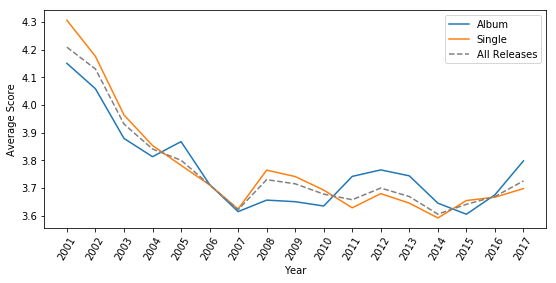

In [40]:
release_type_score_by_year = df.groupby(["release_year","release_type"]).rating.mean().unstack(level=-1)
yearly_average_score = df.groupby("release_year").rating.mean()

plt.figure(figsize=(9,4))
_ = plt.plot(release_type_score_by_year.album)
_ = plt.plot(release_type_score_by_year.single)
_ = plt.plot(yearly_average_score,linestyle="--",c='grey')

plt.xticks(rotation=60)
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend(("Album","Single","All Releases"))
plt.show()

Not really a clear trend of dominance here.

## Have albums always been an important part of RA reviews?

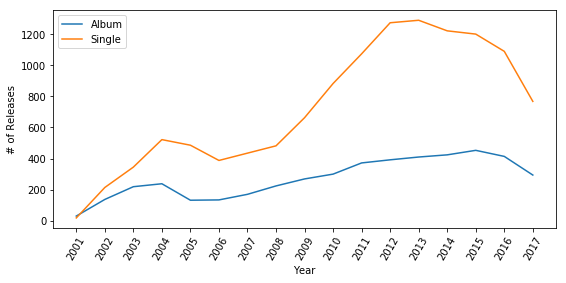

In [47]:
release_type_count_by_year = df.groupby(["release_year","release_type"]).artist.count().unstack(level=-1)

plt.figure(figsize=(9,4))
_ = plt.plot(release_type_count_by_year.album)
_ = plt.plot(release_type_count_by_year.single)

plt.xticks(rotation=60)
plt.xlabel("Year")
plt.ylabel("# of Releases")
plt.legend(("Album","Single"))
plt.show()

Yes, album reviews have always been a significant part of the site's reviews, but starting in 2008, RA appears to have made a clear effort to review more singles

## Are there artists with over 10 reviewed releases that have a particularly high average score?

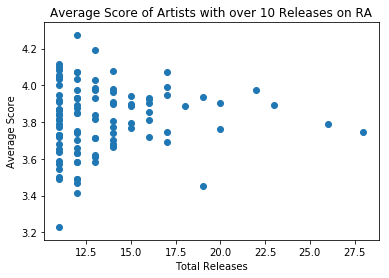

In [163]:
#group by artists and count how many reviews each artist has. Sort descending. Then lop off the first three, as those are Various Artists or unknown
artist_count = df.groupby("artist").rating.count().sort_values(ascending=False).iloc[3:]

#create list of artists with over 10 releases 
artists_over_ten_releases = list(artist_count[artist_count > 10].index)

#compile average ratings for those artists
artist_average = df[df['artist'].isin(artists_over_ten_releases)].groupby("artist").rating.mean()

#merge them into the same dataframe
artist_average = artist_average.to_frame().reset_index()
artist_count = artist_count.to_frame().reset_index()
top_artists_releases_ratings = pd.merge(artist_average,artist_count,how="inner",on="artist").set_index("artist")
top_artists_releases_ratings.columns = ['Avg Rating',"Releases"]

plt.scatter(top_artists_releases_ratings["Releases"],top_artists_releases_ratings["Avg Rating"])
plt.xlabel("Total Releases")
plt.ylabel("Average Score")
plt.title("Average Score of Artists with over 10 Releases on RA")
plt.show()


## Let's compare some label stats

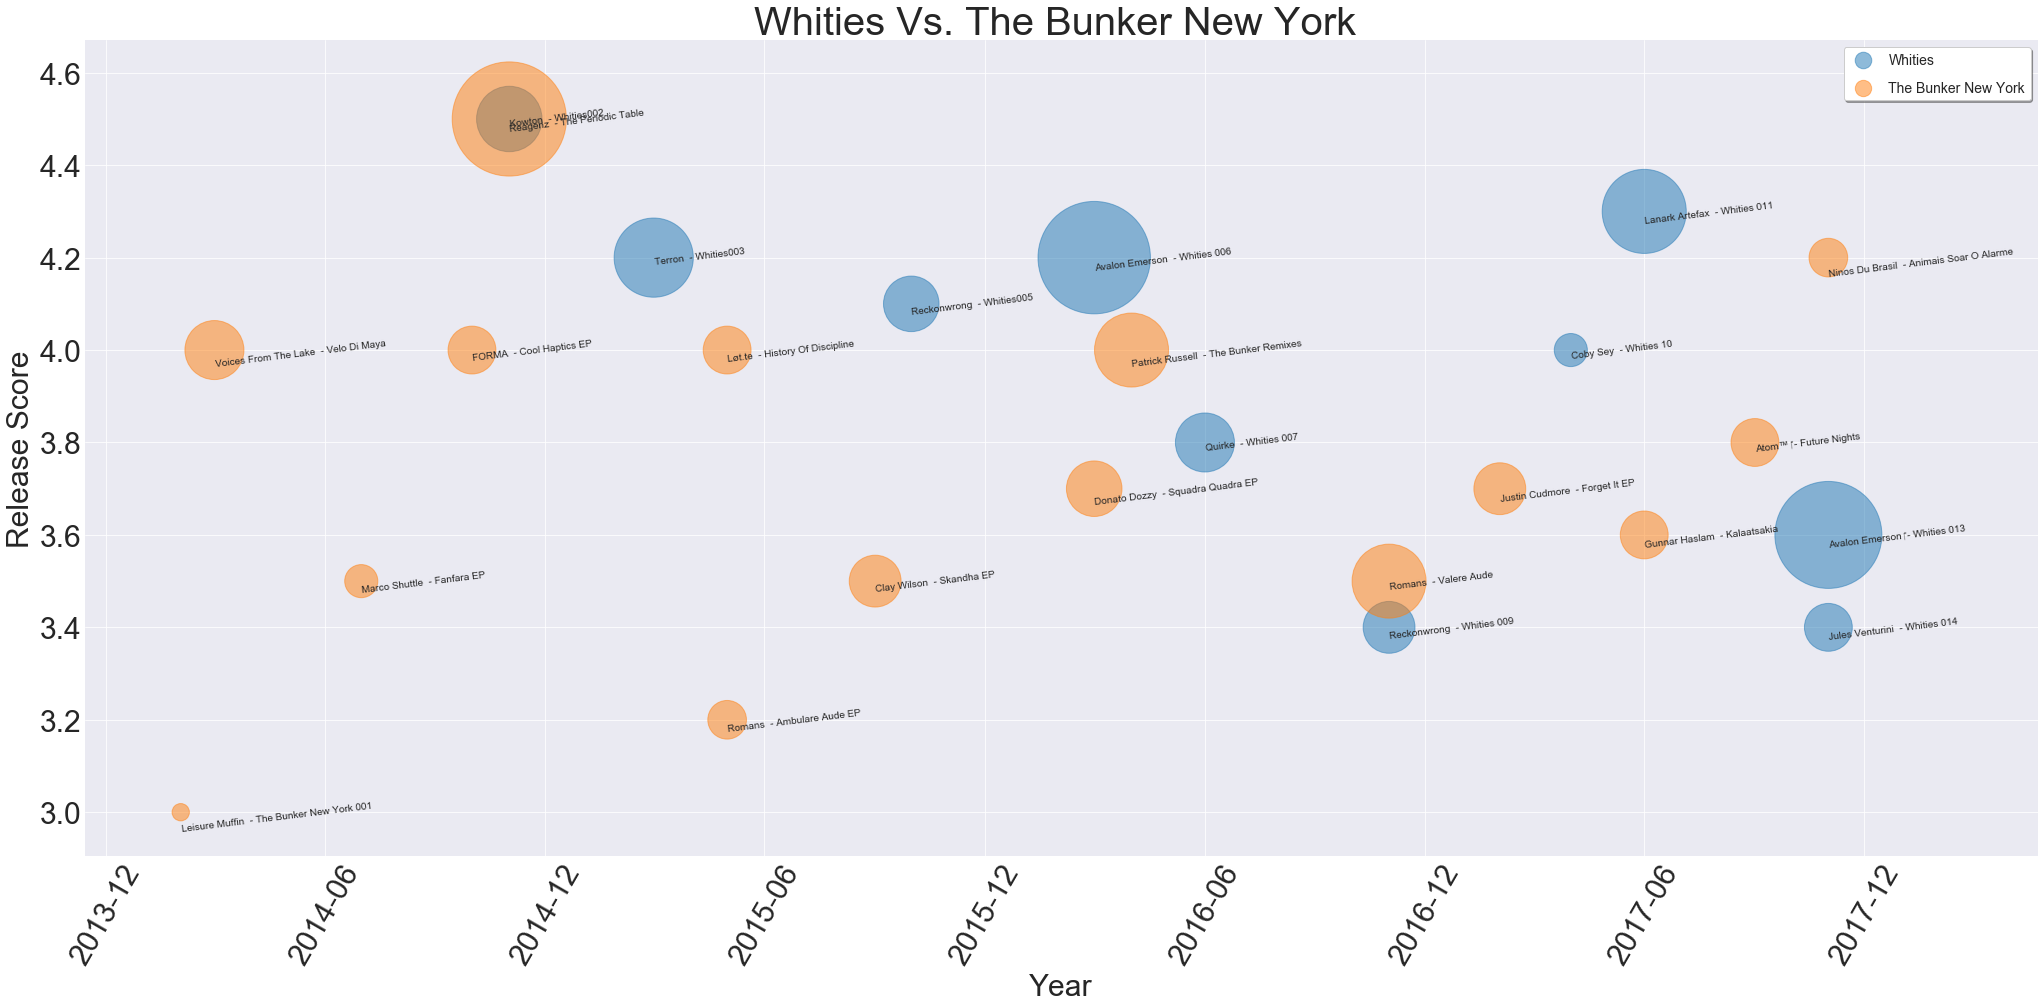

In [384]:
def LabelRatingStats(labels_to_search,show_releases=True):
    
    #chop out relevant labels
    label_results = df[df.label.isin(labels_to_search)]
    
    #elimiate duplicates
    label_results = label_results.sort_values(['artist','release_title','num_comments'],ascending=True).drop_duplicates(["artist",'release_title'],keep='last')
         
    #create datetime array for release dates
    dates = pd.to_datetime(label_results.release_month + " " +label_results.release_year).values
    
    #create list of release artist and release title
    releases = (label_results.artist + " - " + label_results.release_title).values
    
    
    #get plotting data for each label in list and plot
    for label in labels_to_search:
        
        label_rows = label_results[label_results.label == label]
        
        label_dates = pd.to_datetime(label_rows.release_month + " " +label_rows.release_year).values
    
        plt.scatter(label_dates,label_rows.rating,s=(label_rows.num_comments*10**2.6 + 300),alpha=.5)
    
    #create annotations
    if show_releases:
        for i,txt in enumerate(releases):
            plt.annotate(releases[i].decode('utf-8'),
                     (dates[i] ,label_results.rating.iloc[i] + 0.01),
                     rotation=7,size=10
                    )
    
    #format plot and add labels
    plt.xlabel("Year", size=30)
    plt.ylabel("Release Score",size=30)
    plt.xticks(rotation=60,size=30)
    plt.yticks(size=30)
    
    title = ""
    for label in labels_to_search:
        title += label + " Vs. "
    title = title[:-4]
    plt.legend(labels_to_search,markerscale=.2,
               frameon=True,
               fancybox=True,
               shadow=True,
               facecolor="w",
               labelspacing=1,
               fontsize=14)
    plt.title(title,size=40)
    plt.show()
    

#figure controls

sns.set_style("darkgrid")
plt.figure(figsize=(35,15))


########

LabelRatingStats(["Whities","The Bunker New York"],show_releases=True)
# LabelRatingStats(['Ghostly International',"XL Recordings"],show_releases=False)
# LabelRatingStats("Giegling")
# LabelRatingStats("Warp Records")


